## Single cell RNA analysis

#### This notebook follows closely the excellent kallisto/bustool tutorials of the Pachter Lab. Please cite their work.

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os, argparse
%matplotlib inline  

from scipy.io import mmread
import pandas as pd
from sklearn.decomposition import PCA

import scanpy.api as sc
from scipy.stats import gaussian_kde

### prepare the kallisto output

In [3]:
# load kallisto bus output dataset

#load human_mouse transcripts

tr2g = {}
trlist = []
with open('./transcripts.txt') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[0]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('./matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('./output.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]

In [4]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s


15864


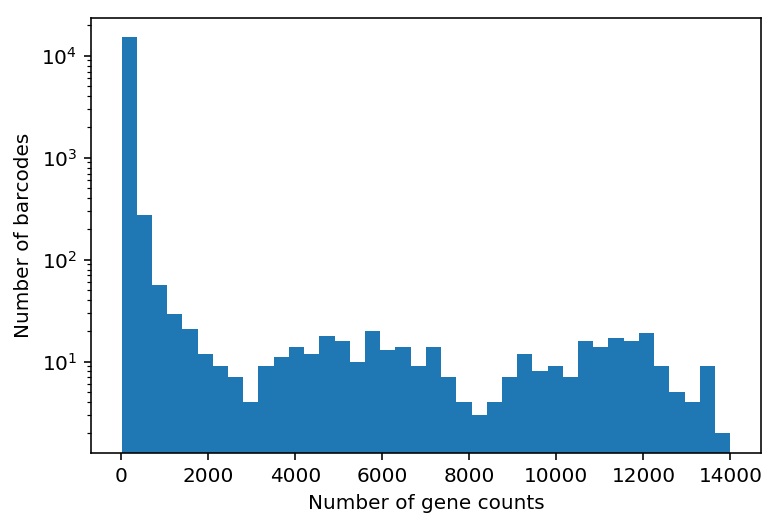

In [5]:
# Take a look at the detected barcodes and genes

threshold = 0 # this filters the data by gene count
bcv = [x for b,x in barcode_hist.items() if x > threshold] 
_ = plt.hist(bcv,bins=40, log=True)
plt.rcParams["figure.figsize"] = [9,6]
plt.xlabel("Number of gene counts")
plt.ylabel("Number of barcodes")
print(len(bcv))

In [6]:
# Export count data as .mtx

outfile = './matrix.mtx'

gene_to_id = dict((g,i+1) for i,g in enumerate(genes))
barcodes_to_use = [b for b,x in barcode_hist.items() if x > 300  and x < 100000] # x > 2000

num_entries = 0
for barcode in barcodes_to_use:
    num_entries += len([x for x in cell_gene[barcode].values() if round(x)>0])

In [7]:
with open(outfile, 'w') as of:
    of.write('%%MatrixMarket matrix coordinate real general\n%\n')
    #number of genes
    of.write("%d %d %d\n"%(len(genes), len(barcodes_to_use), num_entries))
    bcid = 0
    for barcode in barcodes_to_use:
        bcid += 1
        cg = cell_gene[barcode]
        gl = [(gene_to_id[g],round(cg[g])) for g in cg if round(cg[g]) > 0]
        gl.sort()
        for x in gl:
            of.write("%d %d %d\n"%(x[0],bcid,x[1]))

In [8]:
gene_names = {}
with open('./transcript_to_genes_GRCh38_GRCm38.txt') as f:
    f.readline()
    for line in f:
        g,t,gn = line.split()
        gene_names[g] = gn


In [9]:
id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,len(genes)+1):
    g = id_to_genes[i]
    gid = g[:g.find('.')]
    if gid in gene_names:
        gn = gene_names[gid]
    else:
        gn = ''
    gl.append((g,gn))

with open('./genes.tsv','w') as of:
    for g,gn in gl:
        of.write("%s\t%s\n"%(g,gn))

with open('./barcodes.tsv','w') as of:
    of.write('\n'.join(x + '-1' for x in barcodes_to_use))
    of.write('\n')


In [10]:
count_matrix = mmread('./matrix.mtx')
count_matrix


<309785x855 sparse matrix of type '<class 'numpy.float64'>'
	with 779956 stored elements in COOrdinate format>

In [13]:
# Take a peek at what the count matrix look like

dense_count_matrix = count_matrix.todense()
counts_df = pd.DataFrame(dense_count_matrix)
counts_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,845,846,847,848,849,850,851,852,853,854
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Plot PCA
pca = PCA(n_components=20)
pca.fit(dense_count_matrix)
pca_points1 = pca.transform(dense_count_matrix)

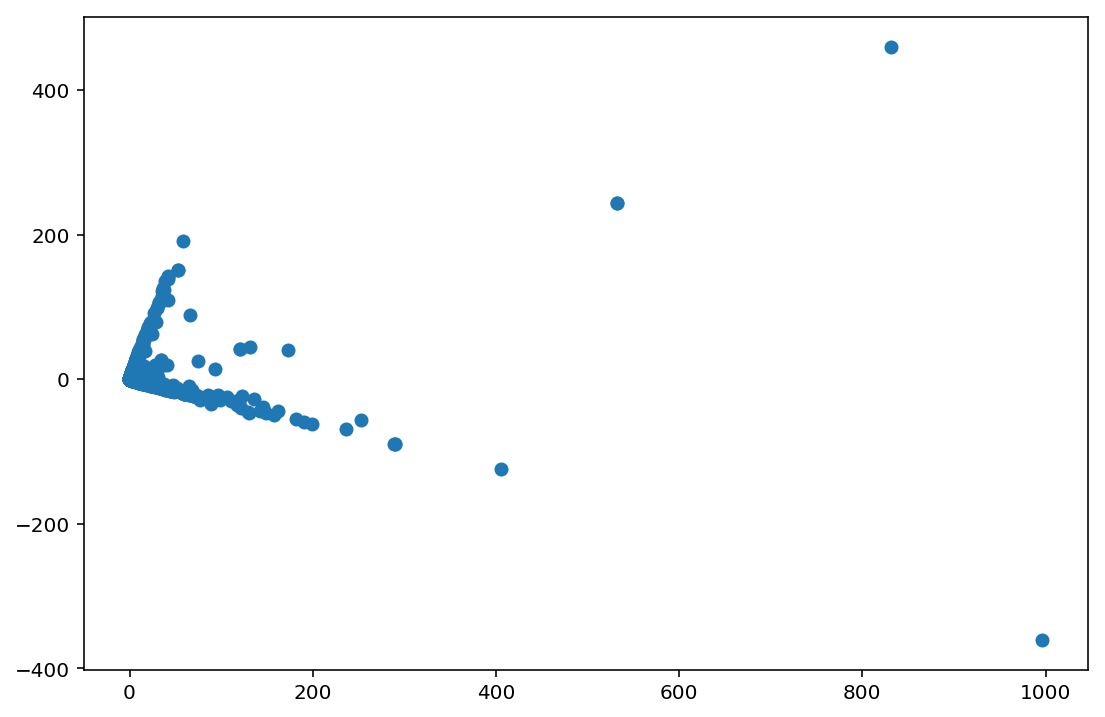

In [15]:
pca_x1 = pca_points1[:,:1,].flatten()
pca_y1 = pca_points1[:,1:2,].flatten()

matplotlib.pyplot.scatter(pca_x1,pca_y1)
plt.show()

### Load gene count matrix, genes and barcodes for plotting

In [37]:
adata = sc.read('./matrix.mtx', cache=False).T  # transpose the data
adata.var_names = pd.read_csv('./genes.tsv', header=None,)[0]
adata.obs_names = pd.read_csv('./barcodes.tsv', header=None)[0]

### Get gene counts for human genes and mouse genes for each cell barcode

In [38]:
human_genes = [name for name in adata.var_names if name.startswith('ENST')]
mouse_genes = [name for name in adata.var_names if name.startswith('ENSMUST')]
# for each cell compute counts in human genes and mouse genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['counts_human'] = np.sum(adata[:, human_genes].X, axis=1).A1
adata.obs['counts_mouse'] = np.sum(adata[:, mouse_genes].X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['counts_total'] = adata.X.sum(axis=1).A1

In [39]:
#Check total number of cell barcodes

print('Total number of cell barcodes:',len(adata.obs))

Total number of cell barcodes: 855


In [40]:
# Check number of cell barcodes with both human & mouse transcripts detected (at least 5% of total transcripts)

print('Number of barcodes with more than 5% mixed transcripts:')
len(adata.obs[(adata.obs['counts_human']>adata.obs['counts_total']*0.05) & (adata.obs['counts_mouse']>adata.obs['counts_total']*0.05)])


Number of barcodes with more than 5% mixed transcripts:


385

### Generate barnyard plot

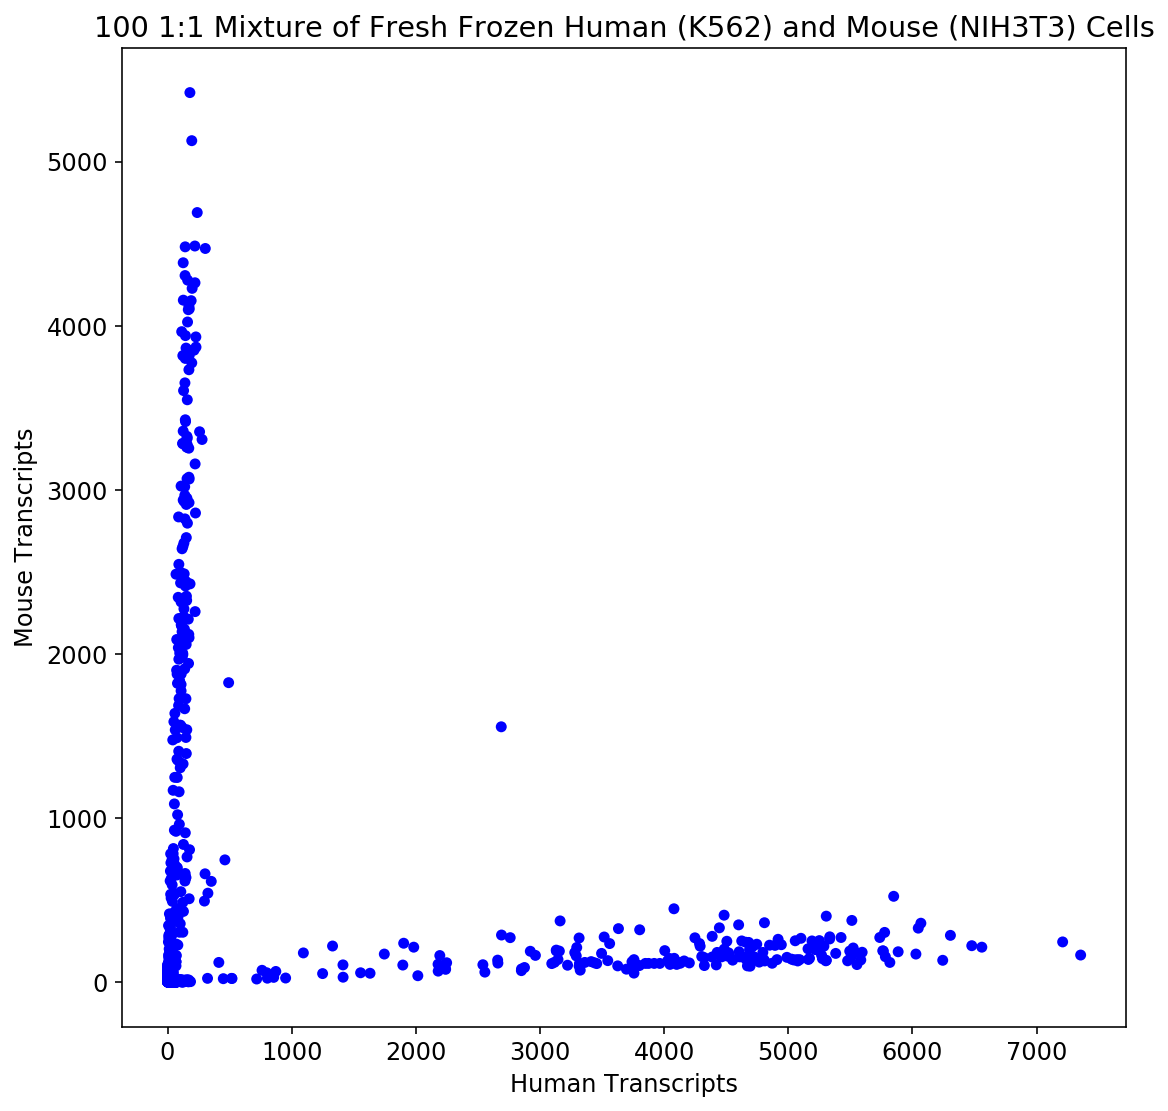

In [41]:
xy = np.vstack([adata.obs['counts_human'], adata.obs['counts_mouse']])
z = gaussian_kde(xy)(xy)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(9,9))
plt.scatter(adata.obs['counts_human'], adata.obs['counts_mouse'], c='b', s=30, edgecolor='', cmap='inferno')
plt.title('100 1:1 Mixture of Fresh Frozen Human (K562) and Mouse (NIH3T3) Cells')
plt.xlabel('Human Transcripts')
plt.ylabel('Mouse Transcripts')
#plt.colorbar()

plt.show()

In [42]:
np.sum(adata.obs['counts_human'] > 500), np.sum(adata.obs['counts_mouse'] > 500)

(191, 181)

In [43]:
expected_num_cells=350

knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
knee[expected_num_cells]

776.0

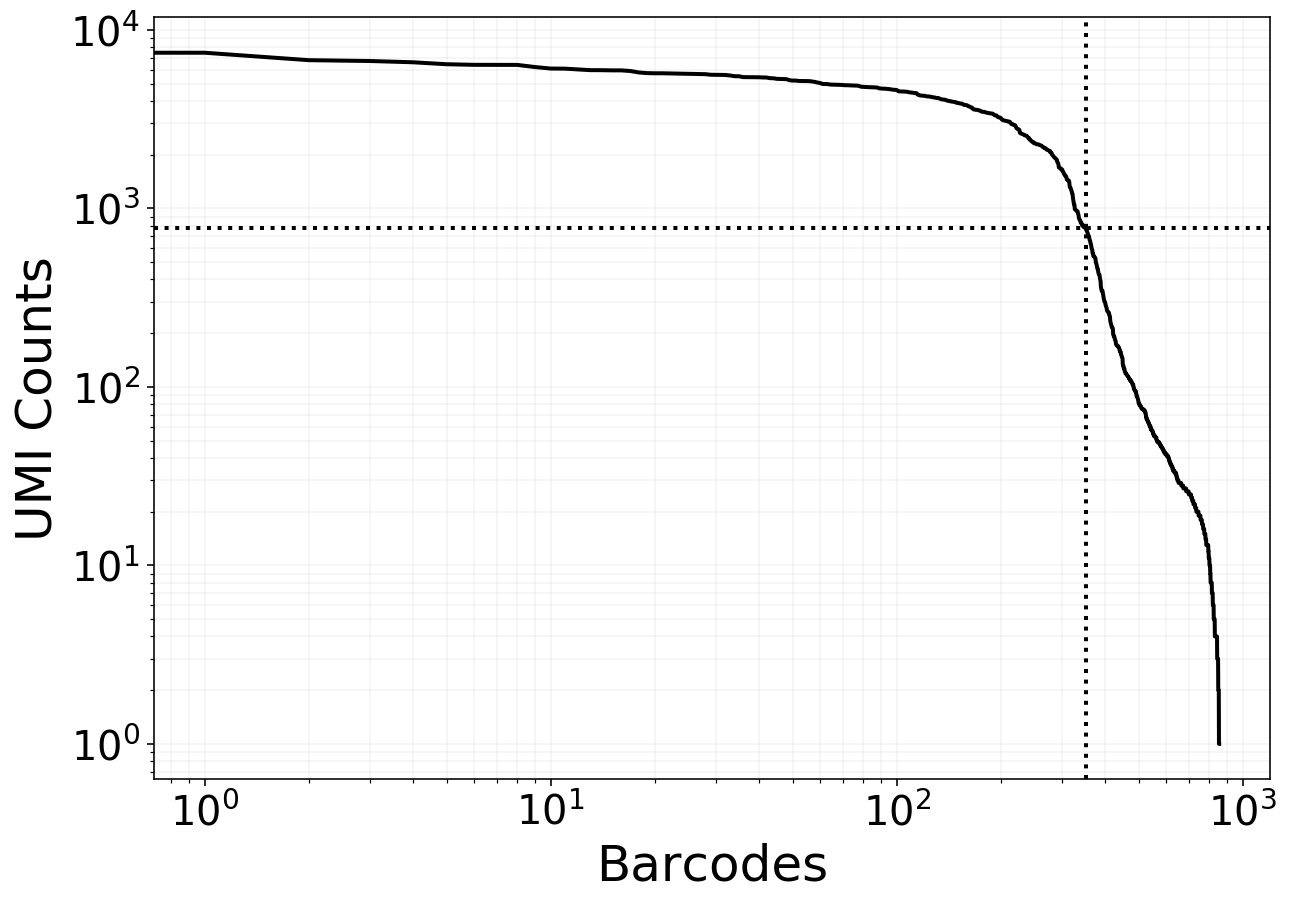

In [44]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(range(len(knee)), knee, linewidth=2, color="k")
ax.axhline(y=775, linewidth=2, color="k", ls=':') # knee[expected_num_cells]
ax.axvline(x=351, linewidth=2, color="k", ls=':')# expected_num_cells

ax.set_ylabel("UMI Counts", size=25)
ax.set_xlabel("Barcodes", size=25)
ax.tick_params(labelsize=20)
plt.grid(True, which="both", lw=.1)
plt.savefig('kneePlot.svg', dpi=600)
plt.show()

In [45]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=775)#knee[expected_num_cells])
sc.pp.filter_genes(adata, min_cells=0)
adata

AnnData object with n_obs × n_vars = 351 × 309785 
    obs: 'counts_human', 'counts_mouse', 'counts_total', 'n_genes', 'n_counts'
    var: 'n_cells'

In [46]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution = 0.2)
sc.tl.umap(adata)

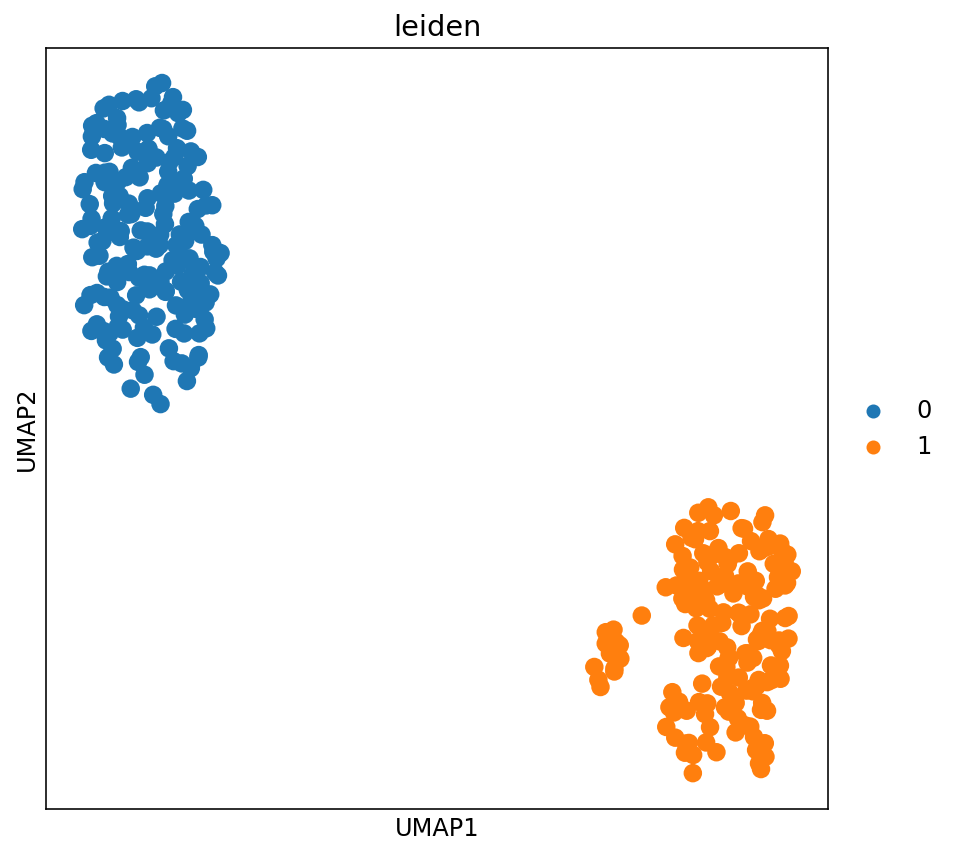

In [50]:
fig, ax = plt.subplots(figsize=(7, 7))
sc.pl.umap(adata, color="leiden", ax=ax, save="mouse_human_umap.svg")

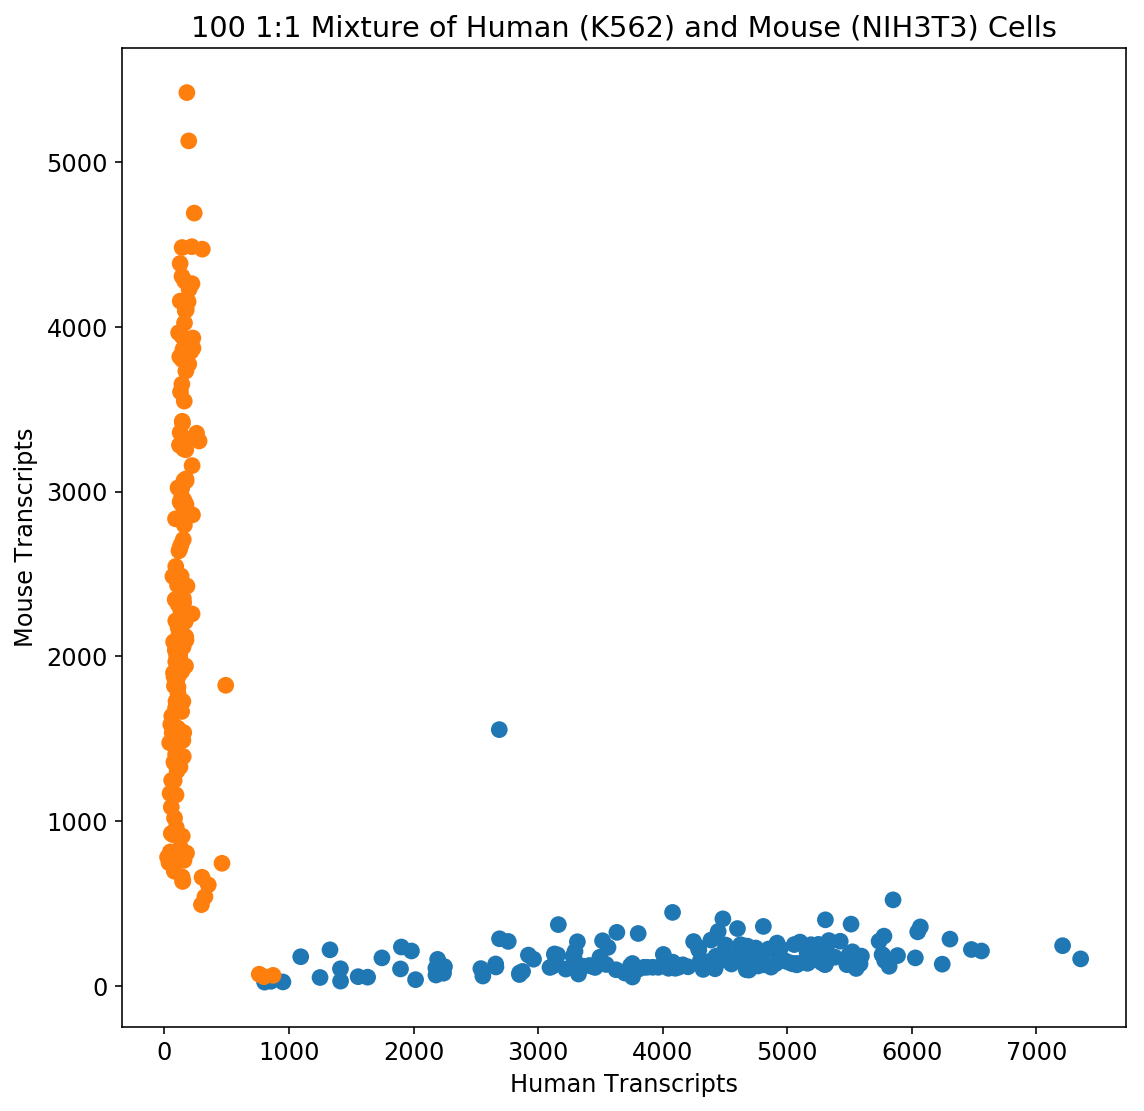

In [52]:
col = []
for i in np.array(adata.obs['leiden']).astype(int):
    col.append(adata.uns['leiden_colors'][i])

xy = np.vstack([adata.obs['counts_human'], adata.obs['counts_mouse']])
z = gaussian_kde(xy)(xy)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(9,9))
plt.scatter(adata.obs['counts_human'], adata.obs['counts_mouse'], c=col, 
            s=70, edgecolor='', cmap='viridis')
plt.title('100 1:1 Mixture of Human (K562) and Mouse (NIH3T3) Cells')
plt.xlabel('Human Transcripts')
plt.ylabel('Mouse Transcripts')
#plt.colorbar()
plt.savefig('barnyard.svg', dpi=600)
plt.show()